Cleaned Version of a Decoder-only (GPT style) transformer architecture.

# Imports

*YOU NEED TO RUN `decoder_thompson_botzercopy.ipynb` before this so you can create the dataset via: `training_data.to_csv("../data/processed/training_data.csv", index=False)`*

In [1]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors
from tokenizers.normalizers import NFKC, Sequence
import os
from typing import List, Optional, Union
from tqdm.notebook import tqdm
from tqdm import tqdm
import random

import transformers
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer, GPT2TokenizerFast
from transformers import PreTrainedTokenizerFast
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, DataCollatorForLanguageModeling
from datasets import Dataset, DatasetDict,load_dataset #, load_metric
from transformers.tokenization_utils_base import AddedToken

# import tensorflow as tf

from sklearn.model_selection import train_test_split

import torch


import ast # Because the tokenized_text column data is stored as a string instead of a list...
import pandas as pd



/mnt/c/Users/et/Documents/Code/AI894/TCG_Generator/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-10 19:57:32.258583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741661854.031781   86040 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741661854.506399   86040 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 19:57:38.903316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instruct

This makes use of the Hugging Face transformer.trainer API so it uses a PyTorch backend

In [2]:
# Check pytorch GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are usisng {device} on a {torch.cuda.get_device_name()}.')

You are usisng cuda on a NVIDIA GeForce RTX 2060 SUPER.


# Grab the dataset

1) Get the dataset
2) Fix the tokenize_text column from a string to a list of strings
3) Pull out all of the words into a mega-list

**SOMTHING IS WRONG WITH THE DATASET.  Likely an issue with the preprocessing steps...**

See:

Item 19152 seems like it is too many cards put together... I need to figure out what is going on.

'Crash Landing — Search your library for a basic land card , reveal it , put it into your hand , then shuffle . \\n Goblin Camp — Create a Treasure token . \\n Emerald Grove — Create a 2/2 white Knight creature token . \\n Auntie\'s Teahouse — Scry 3 . \\n Defiled Temple — You may sacrifice a permanent . If you do , draw a card . \\n Mountain Pass — You may put a land card from your hand onto the battlefield . \\n Ebonlake Grotto — Create two 1/1 blue Faerie Dragon creature tokens with flying . \\n Grymforge — For each opponent , goad up to one target creature that player controls . \\n Githyanki Crèche — Distribute three +1/+1 counters among up to three target creatures you control . \\n Last Light Inn — Draw two cards . \\n Reithwin Tollhouse — Roll 2d4 and create that many Treasure tokens . \\n Moonrise Towers — Instant and sorcery spells you cast this turn cost 3 less to cast . \\n Gauntlet of Shar — Each opponent loses 5 life . \\n Balthazar\'s Lab — Return up to two target creature cards from your graveyard to your hand . \\n Circus of the Last Days — Create a token that\'s a copy of one of your commanders , except it\'s not legendary . \\n Undercity Ruins — Create three 4/1 black Skeleton creature tokens with menace . \\n Steel Watch Foundry — You get an emblem with "Creatures you control get +2/+2 and have trample . " \\n Ansur\'s Sanctum — Reveal the top four cards of your library and put them into your hand . Each opponent loses life equal to those cards\' total mana value . \\n Temple of Bhaal — Creatures your opponents control get -5/-5 until end of turn .'


In [4]:
# Read the processed card data from wherever you have it.

# df = pd.read_csv('../data/processed/mtg_carddata_processed.csv')

# df = pd.read_csv('../data/processed/mtg_carddata_processed_2_23_25.csv')  # Trainer and current process will work with this dataset

df = pd.read_csv('../data/processed/training_data.tsv', sep="\t")

In [5]:
df

,sentence
0,"[start] <THEMES> N Identity , Artifact , N Col..."
1,"[start] <THEMES> N Identity , Artifact , N Col..."
2,"[start] <THEMES> N Identity , Artifact , N Col..."
3,"[start] <THEMES> N Identity , Artifact , N Col..."
4,"[start] <THEMES> N Identity , Artifact , N Col..."
...,...
1295899,"[start] <THEMES> Creature , W Color , Creature..."
1295900,"[start] <THEMES> Creature , W Color , Creature..."
1295901,"[start] <THEMES> Creature , W Color , Creature..."
1295902,"[start] <THEMES> Creature , W Color , Creature..."


In [6]:
df[:7]

,sentence
0,"[start] <THEMES> N Identity , Artifact , N Col..."
1,"[start] <THEMES> N Identity , Artifact , N Col..."
2,"[start] <THEMES> N Identity , Artifact , N Col..."
3,"[start] <THEMES> N Identity , Artifact , N Col..."
4,"[start] <THEMES> N Identity , Artifact , N Col..."
5,"[start] <THEMES> N Identity , Artifact , N Col..."
6,"[start] <THEMES> N Identity , Artifact , N Col..."


In [8]:
df['sentence'][0]

'[start] <THEMES> N Identity , Artifact , N Color , {3} Cost'

In [9]:
corpus = df['sentence']
print(corpus[0:3])

0    [start] <THEMES> N Identity , Artifact , N Col...
1    [start] <THEMES> N Identity , Artifact , N Col...
2    [start] <THEMES> N Identity , Artifact , N Col...
Name: sentence, dtype: object


In [10]:
# Convert corpus to list of strings if it's not already
corpus_list = corpus.tolist() if hasattr(corpus, 'tolist') else list(corpus)

In [11]:
type(corpus)

pandas.core.series.Series

In [12]:
type(corpus_list[0])

str

In [13]:
# Convert pandas Series to list of strings
corpus_list = corpus.values.tolist()

# Ensure all elements are strings
corpus_list = [str(text) for text in corpus_list]

In [14]:
# Corrected the above code to ensure all elements are strings
corpus_list[0]

'[start] <THEMES> N Identity , Artifact , N Color , {3} Cost'

In [15]:
# Check the first few elements to verify
print(type(corpus_list))  # Should show: <class 'list'>
print(type(corpus_list[0]))  # Should show: <class 'str'>

<class 'list'>
<class 'str'>


# Split into train/val/test datasets

Do we need to keep other information with the corpus_list as we split it up?  Names, color, etc.?

If we're just generating text, I think that answer is no.  If we want more, then the answer is likely yes.

In [16]:
# Split data into train/validation/test (80/10/10) sets
train_list, temp = train_test_split(corpus_list, test_size=0.2, random_state=42) # Set 80% for training
val, test = train_test_split(temp, test_size=0.5, random_state=42) # Set 10% for validation and 10% for testing

In [17]:
# Turn them into dicts so I can use them with the Hugging Face Dataset class
train = [{"sentence": text} for text in train_list]  # Wrap each sentence in a dict
val = [{"sentence": text} for text in val]
test = [{"sentence": text} for text in test]

# Create the Dataset Dictionary for future mapping
data = DatasetDict({
    'train': Dataset.from_list(train),
    'validation': Dataset.from_list(val),
    'test': Dataset.from_list(test)
    })

data

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 1036723
    })
    validation: Dataset({
        features: ['sentence'],
        num_rows: 129590
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 129591
    })
})

In [18]:
def df

SyntaxError: expected '(' (4257267261.py, line 1)

In [19]:
del corpus

In [20]:
del train_list

In [21]:
del temp

In [22]:
del train

In [23]:
del val

In [24]:
del test

In [25]:
# Check the items
data['train'][10:20]

{'sentence': ['[start] <THEMES> B Identity , 1 1 Counters , Creature , Sacrifice , Creature Based , B Color , Zombie , {2} {B} Cost <CARD_NAME> <name> <MANA_COST> {2} {B} <TYPE_LINE> Creature — Zombie <ORACLE_TEXT> {1} {B} , Sacrifice another creature : Put two 1 1 counters on <name> . Activate only as a',
  '[start] <THEMES> Damage , Flash , Enchantment , R Color , R Identity , {3} {R} {R} Cost <CARD_NAME> <name> <MANA_COST> {3} {R} {R} <TYPE_LINE> Enchantment <ORACLE_TEXT> Flash \\n If a source would deal damage to a permanent or player , it deals double that damage to that permanent or player instead',
  '[start] <THEMES> {2} {W} Cost , Enchantment , W Color , Tokens , Treasure Tokens , W Identity , Card Draw <CARD_NAME> <name> <MANA_COST> {2} {W} <TYPE_LINE> Enchantment <ORACLE_TEXT> At the beginning',
  '[start] <THEMES> {3} {W} Cost , W Color , Creature Based , Sorcery , Rebound , W Identity <CARD_NAME> <name> <MANA_COST> {3} {W} <TYPE_LINE> Sorcery <ORACLE_TEXT> Creatures you co

In [26]:
data['validation']['sentence'][0]

'[start] <THEMES> Storage Counters , Land , Cost , U Identity , N Color <CARD_NAME> <name> <MANA_COST> <TYPE_LINE> Land <ORACLE_TEXT> <name> enters tapped . \\n {T} : Put a storage counter on <name> . \\n {T} ,'

# Train the Tokenizer on Training Data

Keep the validation and test sets out of the tokenizer to prevent data leakage.

In [27]:
# Create a directory for tokenizer files if it doesn't exist
models_dir = "../models/themed_data"
os.makedirs(models_dir, exist_ok=True)

## Tokenizer Functions

1) `create_gpt2_tokenizer`

2) `train_tokenizer_from_texts`

3) `convert_to_transformers_tokenizer` -> This is important to allow `trainer.train` to work

4) `use_transformers_tokenizer`

5) `load_transformers_tokenizer` -> Used if you have one to load, else just carry from `tokenizer=convert_to_transformers_tokenizer`

6) `demonstrate_workflow2` -> make sure this whole thing even works...

In [28]:
def create_gpt2_tokenizer(vocab_size=8192, min_frequency=2):
    """
    Create a GPT2-style BPE tokenizer from scratch using Hugging Face tokenizers library.

    Args:
        vocab_size: The size of the vocabulary to learn
        min_frequency: Minimum frequency for a token to be considered in the BPE algorithm

    Returns:
        A tokenizer object ready for training
    """
    # Initialize a ByteLevelBPE model-based tokenizer
    tokenizer = Tokenizer(models.BPE())

    # Add byte-level pre-tokenizer
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

    # Add decoder to properly decode byte-level tokens
    tokenizer.decoder = decoders.ByteLevel()

    # Set up normalizers - GPT-2 doesn't do much normalization
    tokenizer.normalizer = Sequence([NFKC()])

    # Return the tokenizer (to be trained later)
    return tokenizer


def train_tokenizer_from_texts(
    tokenizer: Tokenizer,
    texts: List[str],
    vocab_size: int = 8192,
    min_frequency: int = 2,
    batch_size: int = 512,
    output_dir: str = "tokenizer"
):
    """
    Train the tokenizer on a list of texts using batching

    Args:
        tokenizer: The tokenizer object to train
        texts: List of strings to use for training
        vocab_size: Maximum vocabulary size
        min_frequency: Minimum frequency for a token
        batch_size: Number of texts to process in each batch
        output_dir: Directory to save the trained tokenizer

    Returns:
        The trained tokenizer
    """
    if not texts:
        raise ValueError("No texts provided for training")

    # Configure the BPE trainer
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["<|endoftext|>", "<|pad|>"],
        show_progress=True,
    )

    # Create temporary files for batched training
    temp_dir = os.path.join(output_dir, "temp")
    os.makedirs(temp_dir, exist_ok=True)

    # Split texts into batches
    batches = [texts[i:i+batch_size] for i in range(0, len(texts), batch_size)]
    batch_files = []

    print(f"Preparing {len(batches)} batches for training...")

    # Write batches to temporary files
    for i, batch in enumerate(tqdm(batches)):
        batch_file = os.path.join(temp_dir, f"batch_{i}.txt")
        with open(batch_file, "w", encoding="utf-8") as f:
            f.write("\n<|endoftext|>\n".join(batch))
            f.write("\n<|endoftext|>\n")  # Add final separator
        batch_files.append(batch_file)

    # Train the tokenizer
    print("Training tokenizer...")
    tokenizer.train(batch_files, trainer)

    # Add post-processor to handle special tokens
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

    # Enable padding with the PAD token
    pad_id = tokenizer.token_to_id("<|pad|>")
    if pad_id is not None:
        tokenizer.enable_padding(pad_id=pad_id, pad_token="<|pad|>")
    else:
        print("Warning: <|pad|> token not found in vocabulary. Padding won't work correctly.")

    # Save the trained tokenizer
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    tokenizer.save(f"{output_dir}/gpt2_tokenizer.json")

    # Clean up temporary files
    for file in batch_files:
        os.remove(file)
    os.rmdir(temp_dir)

    print(f"Tokenizer trained and saved to {output_dir}/gpt2_tokenizer.json")
    return tokenizer


def convert_to_transformers_tokenizer(
    tokenizer_path: str,
    output_dir: str = None,
    model_max_length: int = 1024
):
    """
    Convert a trained tokenizers.Tokenizer to a transformers compatible tokenizer

    Args:
        tokenizer_path: Path to the saved tokenizer JSON file
        output_dir: Directory to save the transformers tokenizer
        model_max_length: Maximum sequence length for the model

    Returns:
        A transformers-compatible tokenizer
    """
    # Load the tokenizer
    if isinstance(tokenizer_path, Tokenizer):
        # If a tokenizer object is passed directly
        raw_tokenizer = tokenizer_path
    else:
        # Load from file
        raw_tokenizer = Tokenizer.from_file(tokenizer_path)

    # Define special tokens
    eos_token = "<|endoftext|>"  # GPT-2 uses EOS as both BOS and EOS
    pad_token = "<|pad|>"

    # Create the transformers wrapper
    transformers_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=raw_tokenizer,
        bos_token=eos_token,  # GPT-2 uses EOS as BOS too
        eos_token=eos_token,
        pad_token=pad_token,
        unk_token=eos_token,  # GPT-2 doesn't really have UNK, defaults to EOS
        model_max_length=model_max_length
    )

    # Set additional GPT-2 specific attributes
    transformers_tokenizer.add_special_tokens({
        "eos_token": eos_token,
        "bos_token": eos_token,
        "pad_token": pad_token,
    })

    # Save the transformers tokenizer if an output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        transformers_tokenizer.save_pretrained(output_dir)
        print(f"Transformers tokenizer saved to {output_dir}")

    return transformers_tokenizer


def use_transformers_tokenizer(tokenizer, text, padding=True, truncation=True, max_length=None, return_tensors=None):
    """
    Demonstrate how to use the transformers tokenizer

    Args:
        tokenizer: The transformers tokenizer
        text: Text to tokenize or list of texts
        padding: Whether to pad the sequences (True, False, 'max_length', 'longest')
        truncation: Whether to truncate sequences (True, False)
        max_length: Maximum length for padding/truncation (defaults to model_max_length if None)
        return_tensors: Return format for tensors ('pt' for PyTorch, 'tf' for TensorFlow, None for lists)

    Returns:
        Encoding object(s) with tokens, ids, etc.
    """
    # Configure parameters
    if max_length is None:
        max_length = tokenizer.model_max_length

    # Encode the text(s)
    encoded = tokenizer(
        text,
        padding=padding,
        truncation=truncation,
        max_length=max_length,
        return_tensors=return_tensors
    )

    # Display results for single text if it's a string
    if isinstance(text, str):
        print(f"Input text: {text}")
        print(f"Token IDs: {encoded['input_ids'].tolist()[0] if return_tensors else encoded['input_ids']}")
        tokens = tokenizer.convert_ids_to_tokens(
            encoded['input_ids'].tolist()[0] if return_tensors else encoded['input_ids']
        )
        print(f"Tokens: {tokens}")

        if padding:
            print(f"Attention mask: {encoded['attention_mask'].tolist()[0] if return_tensors else encoded['attention_mask']}")

        # Decoding demonstration
        decoded = tokenizer.decode(
            encoded['input_ids'].tolist()[0] if return_tensors else encoded['input_ids'],
            skip_special_tokens=True
        )
        print(f"Decoded text: {decoded}")

    return encoded


def load_transformers_tokenizer(path):
    """
    Load a previously saved transformers tokenizer

    Args:
        path: Path to the saved transformers tokenizer directory

    Returns:
        The loaded transformers tokenizer
    """
    return GPT2TokenizerFast.from_pretrained(path)


def demonstrate_workflow2():
    """
    Full demonstration of creating, training, and using a GPT-2 style tokenizer
    that's compatible with the transformers library
    """
    # Create a new tokenizer
    print("Creating tokenizer...")
    tokenizer = create_gpt2_tokenizer()

    # Generate some sample texts for demonstration
    print("Generating sample texts...")
    sample_texts = [
        "This is an example of text that could be used to train a tokenizer.",
        "It should include diverse vocabulary, punctuation (like commas, periods, question marks?).",
        "Multiple paragraphs are good to include.",
        "Numbers like 42, 3.14159, and 2023 should be represented.",
        "Code snippets might be important if your model will process code:\ndef hello_world():\n    print('Hello, world!')",
    ]

    # Add some more generated texts for better training
    for i in range(50):
        words = ["The", "quick", "brown", "fox", "jumps", "over", "lazy", "dog",
                "Hello", "world", "Python", "programming", "is", "fun", "GPT",
                "natural", "language", "processing", "models", "work", "well"]
        length = random.randint(5, 20)
        text = " ".join(random.choices(words, k=length)) + "."
        sample_texts.append(text)

    # Train the tokenizer on the sample texts
    print(f"Training tokenizer on {len(sample_texts)} texts...")
    raw_tokenizer = train_tokenizer_from_texts(
        tokenizer,
        sample_texts,
        vocab_size=1000,  # Smaller vocab for demo
        min_frequency=1,
        batch_size=20,
        output_dir="tokenizer_demo"
    )

    # Convert to transformers tokenizer
    print("\nConverting to transformers tokenizer...")
    transformers_tokenizer = convert_to_transformers_tokenizer(
        "tokenizer_demo/gpt2_tokenizer.json",
        output_dir="transformers_tokenizer_demo",
        model_max_length=512
    )

    # Test the transformers tokenizer
    print("\nTesting transformers tokenizer...")
    test_texts = [
        "This is a short text.",
        "This is a slightly longer text with more content.",
        "Let's see how padding works on texts of different lengths."
    ]

    # Encode with transformers tokenizer (return PyTorch tensors)
    print("\nEncoding with PyTorch tensors:")
    encodings = use_transformers_tokenizer(
        transformers_tokenizer,
        test_texts,
        padding=True,
        return_tensors="pt"
    )

    # Show that it can be saved and loaded
    print("\nLoading saved transformers tokenizer:")
    loaded_tokenizer = load_transformers_tokenizer("transformers_tokenizer_demo")
    test_encode = loaded_tokenizer(
        "Testing that loading works correctly.",
        return_tensors="pt"
    )
    print(f"Encoded IDs: {test_encode['input_ids'].tolist()[0]}")
    print(f"Decoded: {loaded_tokenizer.decode(test_encode['input_ids'][0])}")

    return transformers_tokenizer

In [29]:
# Check if this even works...
demonstrate_workflow2()

Creating tokenizer...
Generating sample texts...
Training tokenizer on 55 texts...
Preparing 3 batches for training...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 261.29it/s]

Training tokenizer...



Tokenizer trained and saved to tokenizer_demo/gpt2_tokenizer.json

Converting to transformers tokenizer...
Transformers tokenizer saved to transformers_tokenizer_demo

Testing transformers tokenizer...

Encoding with PyTorch tensors:

Loading saved transformers tokenizer:



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.


Encoded IDs: [26, 133, 47, 76, 286, 56, 39, 42, 28, 31, 76, 102, 46, 162, 62, 179, 215, 39, 52, 7]
Decoded: Testing that loading works correctly.


PreTrainedTokenizerFast(name_or_path='', vocab_size=337, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|pad|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|pad|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

## Create and train the tokenizer

In [30]:
# Train a tokenizer if you don't have one yet
trained_tokenizer = create_gpt2_tokenizer(vocab_size=8192, min_frequency=2)

# This saves the tokenizer out to memory as well
trained_tokenizer = train_tokenizer_from_texts(tokenizer=trained_tokenizer, texts=data['train']['sentence'], batch_size=512, output_dir=models_dir)


Preparing 2025 batches for training...


100%|██████████████████████████████████████████████████████████████████████████████| 2025/2025 [00:11<00:00, 181.52it/s]


Training tokenizer...



Tokenizer trained and saved to ../models/themed_data/gpt2_tokenizer.json


In [31]:
# This pulls the trained_tokenizer and makes it compatable with the transformers library for training
# Needs to be a PreTrainedTokenizerFast object
tokenizer_fast = convert_to_transformers_tokenizer(tokenizer_path=f"{models_dir}/gpt2_tokenizer.json",
                                                   output_dir=models_dir, model_max_length=256)

# Check the tokenizer
tokenizer_fast

Transformers tokenizer saved to ../models/themed_data


PreTrainedTokenizerFast(name_or_path='', vocab_size=7490, model_max_length=256, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|pad|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|pad|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [32]:
# Check to make sure the fast tokenizer is working
encodings = use_transformers_tokenizer(tokenizer_fast, data['validation']['sentence'][1], padding=True, max_length=1024, return_tensors='pt')
encodings

Input text: [start] <THEMES> N Identity , Creature Based , Artifact , N Color , {3} Cost <CARD_NAME> <name> <MANA_COST>
Token IDs: [48, 128, 50, 91, 140, 21, 253, 132, 90, 112, 183, 90, 238, 90, 253, 129, 90, 93, 12, 80, 127, 91, 145, 51, 146, 21, 91, 117, 21, 91, 149, 51, 151, 21]
Tokens: ['[', 'start', ']', 'Ġ<', 'THEMES', '>', 'ĠN', 'ĠIdentity', 'Ġ,', 'ĠCreature', 'ĠBased', 'Ġ,', 'ĠArtifact', 'Ġ,', 'ĠN', 'ĠColor', 'Ġ,', 'Ġ{', '3', '}', 'ĠCost', 'Ġ<', 'CARD', '_', 'NAME', '>', 'Ġ<', 'name', '>', 'Ġ<', 'MANA', '_', 'COST', '>']
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded text: [start] <THEMES> N Identity , Creature Based , Artifact , N Color , {3} Cost <CARD_NAME> <name> <MANA_COST>


{'input_ids': tensor([[ 48, 128,  50,  91, 140,  21, 253, 132,  90, 112, 183,  90, 238,  90,
         253, 129,  90,  93,  12,  80, 127,  91, 145,  51, 146,  21,  91, 117,
          21,  91, 149,  51, 151,  21]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

# Tokenize all of the data

## Functions

In [33]:
def tokenize_dataset_dict(dataset_dict, tokenizer, max_length=None, batch_size=1000):
    """
    Tokenize all sentence entries in a Hugging Face DatasetDict.

    Args:
        dataset_dict: A Hugging Face DatasetDict containing data with 'sentence' column
        tokenizer: A transformers tokenizer
        max_length: Maximum sequence length for tokenization (None = no limit)
        batch_size: Batch size for processing

    Returns:
        A new DatasetDict with tokenized data
    """
    from datasets import DatasetDict

    # Function to tokenize a batch of examples
    def tokenize_function(examples):
        # For transformers tokenizers use the __call__ method
        return tokenizer(
            examples["sentence"],
            padding="max_length" if max_length else False,
            truncation=True if max_length else False,
            max_length=max_length,
            return_special_tokens_mask=True,
        )

    # Create a new DatasetDict to store the tokenized datasets
    tokenized_datasets = DatasetDict()

    # Process each split in the dataset
    for split_name, dataset in dataset_dict.items():
        # Map the tokenize function over the dataset in batches
        tokenized_datasets[split_name] = dataset.map(
            tokenize_function,
            batched=True,
            batch_size=batch_size,
            # remove_columns=["sentence"] if "sentence" in dataset.column_names else None, # Keep the sentences
            desc=f"Tokenizing {split_name} split",
        )

        # Print the first example to verify
        if len(tokenized_datasets[split_name]) > 0:
            print(f"\nExample from {split_name} split:")
            example = tokenized_datasets[split_name][0]
            print(f"Input IDs (first 10): {example['input_ids'][:10]}...")
            print(f"Attention Mask (first 10): {example['attention_mask'][:10]}...")

            # Decode a sample for verification
            decoded = tokenizer.decode(example['input_ids'])
            print(f"Decoded sample preview: {decoded[:50]}...")

    return tokenized_datasets

## Tokenize the Datasets

Do we need to do this?  I think so... I can train when I do this so... yes?

In [34]:
# Tokenize the DatasetDict
# TODO: We can probably decrease the max_length here to 128 or 64 to save memory; We'll have to test it out
# Or maybe we don't use a max length...?? TODO: Figure out how to handle this
tokenize_dataset_dict = tokenize_dataset_dict(data, tokenizer_fast, max_length=256, batch_size=1000)
tokenize_dataset_dict

Tokenizing train split: 100%|████████████████████████████████████████| 1036723/1036723 [03:19<00:00, 5200.82 examples/s]



Example from train split:
Input IDs (first 10): [48, 128, 50, 91, 140, 21, 317, 90, 188, 129]...
Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Decoded sample preview: [start] <THEMES> Damage , R Color , {1} {R} Cost ,...


Tokenizing validation split: 100%|█████████████████████████████████████| 129590/129590 [00:24<00:00, 5331.51 examples/s]



Example from validation split:
Input IDs (first 10): [48, 128, 50, 91, 140, 21, 2608, 312, 90, 418]...
Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Decoded sample preview: [start] <THEMES> Storage Counters , Land , Cost , ...


Tokenizing test split: 100%|███████████████████████████████████████████| 129591/129591 [00:24<00:00, 5332.76 examples/s]


Example from test split:
Input IDs (first 10): [48, 128, 50, 91, 140, 21, 547, 129, 90, 112]...
Attention Mask (first 10): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Decoded sample preview: [start] <THEMES> BR Color , Creature , {4} {B} {R}...


DatasetDict({
    train: Dataset({
        features: ['sentence', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 1036723
    })
    validation: Dataset({
        features: ['sentence', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 129590
    })
    test: Dataset({
        features: ['sentence', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 129591
    })
})

In [35]:
# Make sure 'sentnece' is still there
tokenize_dataset_dict['validation']['sentence'][0]

'[start] <THEMES> Storage Counters , Land , Cost , U Identity , N Color <CARD_NAME> <name> <MANA_COST> <TYPE_LINE> Land <ORACLE_TEXT> <name> enters tapped . \\n {T} : Put a storage counter on <name> . \\n {T} ,'

In [36]:
tokenize_dataset_dict['validation']['input_ids'][0]

[48,
 128,
 50,
 91,
 140,
 21,
 2608,
 312,
 90,
 418,
 90,
 127,
 90,
 200,
 132,
 90,
 253,
 129,
 91,
 145,
 51,
 146,
 21,
 91,
 117,
 21,
 91,
 149,
 51,
 151,
 21,
 91,
 159,
 51,
 157,
 21,
 418,
 91,
 172,
 51,
 173,
 21,
 91,
 117,
 21,
 302,
 660,
 164,
 191,
 65,
 93,
 41,
 80,
 270,
 575,
 186,
 2647,
 408,
 257,
 91,
 117,
 21,
 164,
 191,
 65,
 93,
 41,
 80,
 90,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,

In [37]:
# A short function to easily convert from ids_to_tokens
# It effectivly just wraps the decode function
def ids_to_tokens(tokenizer, ids):
    '''
    Convert token IDs back to tokens using the tokenizer
    Really just a mapping function for tokenizer.decode()
    '''
    tokens = tokenizer.decode(ids)

    return tokens

In [38]:
trained_tokenizer.decode(tokenize_dataset_dict['validation']['input_ids'][0])

'[start] <THEMES> Storage Counters , Land , Cost , U Identity , N Color <CARD_NAME> <name> <MANA_COST> <TYPE_LINE> Land <ORACLE_TEXT> <name> enters tapped . \\n {T} : Put a storage counter on <name> . \\n {T} ,'

In [39]:
ids_to_tokens(trained_tokenizer, tokenize_dataset_dict['validation']['input_ids'][0])

'[start] <THEMES> Storage Counters , Land , Cost , U Identity , N Color <CARD_NAME> <name> <MANA_COST> <TYPE_LINE> Land <ORACLE_TEXT> <name> enters tapped . \\n {T} : Put a storage counter on <name> . \\n {T} ,'

In [ ]:
tokenize_dataset_dict['validation']['attention_mask'][0]

In [40]:
del data

## Set formating to torch of the DatasetDict

In [41]:
# Make sure the tokenized dataset is in the correct format for PyTorch

# old
# tokenize_dataset_dict.set_format(type='torch', columns=['sentence', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'])

# New
tokenize_dataset_dict.set_format(type='torch', columns=['sentence', 'input_ids', 'token_type_ids', 'attention_mask', 'special_tokens_mask'])

### Check shapes

In [42]:
# Note that these have been padded out to the max_length

for i in range(0, 11):
    print(tokenize_dataset_dict['train'][i]['input_ids'].shape)

torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])


In [43]:
for i in range(0, 11):
    print(tokenize_dataset_dict['train'][i]['attention_mask'].shape)

torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])


In [44]:
for i in range(0, 11):
    print(tokenize_dataset_dict['train'][i]['sentence'])

[start] <THEMES> B Identity , 1 1 Counters , Creature , Sacrifice , Creature Based , B Color , Zombie , {2} {B} Cost <CARD_NAME> <name> <MANA_COST> {2} {B} <TYPE_LINE> Creature — Zombie <ORACLE_TEXT> {1} {B} , Sacrifice another creature : Put two 1 1 counters on <name> . Activate only as a
[start] <THEMES> Damage , Flash , Enchantment , R Color , R Identity , {3} {R} {R} Cost <CARD_NAME> <name> <MANA_COST> {3} {R} {R} <TYPE_LINE> Enchantment <ORACLE_TEXT> Flash \n If a source would deal damage to a permanent or player , it deals double that damage to that permanent or player instead
[start] <THEMES> {2} {W} Cost , Enchantment , W Color , Tokens , Treasure Tokens , W Identity , Card Draw <CARD_NAME> <name> <MANA_COST> {2} {W} <TYPE_LINE> Enchantment <ORACLE_TEXT> At the beginning
[start] <THEMES> {3} {W} Cost , W Color , Creature Based , Sorcery , Rebound , W Identity <CARD_NAME> <name> <MANA_COST> {3} {W} <TYPE_LINE> Sorcery <ORACLE_TEXT> Creatures you control get 2 1 until end of turn

# Build the Decoder

## A Short Rebuild of the above but with Hugging Face API

We might be able to leverage accelerated training by using HF so this could be worth to have.  It also uses a PyTorch backend which I know works on Brandon's system... TensorFlow has been giving me problems in my environment lately.

In [45]:
# Grab the decoder-only setup
from transformers import GPT2Config, GPT2LMHeadModel

In [46]:
# Make the model

VOCAB_SIZE = 8912 # Define this based on training data vocab size / tokenize size.
# TODO: Or does it need to relate to the tokenizer?
SEQUENCE_LENGTH = 500 # Define this based on training data sequence length. aka. context window
EMBEDDING_DIM = 512 # Configure
FEED_FORWARD_DIM = 4 * EMBEDDING_DIM # Standard for decoder-only items.
DROPOUT = 0.5 # Configure
NUM_HEADS = 16 # Configure attention heads
NUM_DECODER_LAYERS = 4 # Configure

# Define the model configuration
model_config = GPT2Config(
    vocab_size=VOCAB_SIZE,
    n_positions=SEQUENCE_LENGTH,
    n_ctx=SEQUENCE_LENGTH,
    n_embd=EMBEDDING_DIM,
    n_layer=NUM_DECODER_LAYERS,
    n_head=NUM_HEADS,
    resid_pdrop=DROPOUT,
    embd_pdrop=DROPOUT,
    attn_pdrop=DROPOUT,
    # layer_norm_epsilon=1e-5,
    # initializer_range=0.02,
)

# Initialize the model
gptmodel = GPT2LMHeadModel(model_config)
# Output the model layers for inspection
gptmodel

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(8912, 512)
    (wpe): Embedding(500, 512)
    (drop): Dropout(p=0.5, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=1536, nx=512)
          (c_proj): Conv1D(nf=512, nx=512)
          (attn_dropout): Dropout(p=0.5, inplace=False)
          (resid_dropout): Dropout(p=0.5, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=2048, nx=512)
          (c_proj): Conv1D(nf=512, nx=2048)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.5, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=512, out_features=8912, bias=False)
)

In [47]:
# Check the number of trainable parameters.
# How many trainable parameters exist in the gptmodel? (setting p.requires_grad to True for this)
trainable_params = sum(p.numel() for p in gptmodel.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainable_params)

Number of trainable parameters: 17429504


In [48]:
# Print each parameter's name and trainable count individually
for name, param in gptmodel.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} trainable parameters")

transformer.wte.weight: 4562944 trainable parameters
transformer.wpe.weight: 256000 trainable parameters
transformer.h.0.ln_1.weight: 512 trainable parameters
transformer.h.0.ln_1.bias: 512 trainable parameters
transformer.h.0.attn.c_attn.weight: 786432 trainable parameters
transformer.h.0.attn.c_attn.bias: 1536 trainable parameters
transformer.h.0.attn.c_proj.weight: 262144 trainable parameters
transformer.h.0.attn.c_proj.bias: 512 trainable parameters
transformer.h.0.ln_2.weight: 512 trainable parameters
transformer.h.0.ln_2.bias: 512 trainable parameters
transformer.h.0.mlp.c_fc.weight: 1048576 trainable parameters
transformer.h.0.mlp.c_fc.bias: 2048 trainable parameters
transformer.h.0.mlp.c_proj.weight: 1048576 trainable parameters
transformer.h.0.mlp.c_proj.bias: 512 trainable parameters
transformer.h.1.ln_1.weight: 512 trainable parameters
transformer.h.1.ln_1.bias: 512 trainable parameters
transformer.h.1.attn.c_attn.weight: 786432 trainable parameters
transformer.h.1.attn.c_at

There is a difference in the reported number of trained parameters between Etienne's custom build and the Hugging Face model.

I'm 90% certain it has to do with the positional eoncodings being done slightly different.  48M of his model parameters are from the PosEnc which doesn't show up the same way in the GPT-model.

Both models are likely to generate similar results.

# Training the Model

## Setup Training Arguments

In [49]:
# Set up the Training Args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5, # Prior runs show that I am easily over fitting the data at 25 epochs...
    weight_decay=0.01,
    logging_dir='./logs',
    # logging_steps=10, # This made my loss vs epoch plot too noisy...
    logging_strategy='epoch',
    save_strategy='epoch',
)

In [50]:
# Set up the Trainer

#mlm is the masked language modeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer_fast, mlm=False, return_tensors='pt')

trainer = Trainer(
    model=gptmodel,
    args=training_args,
    train_dataset=tokenize_dataset_dict['train'],
    eval_dataset=tokenize_dataset_dict['validation'],
    processing_class=tokenizer_fast,
    data_collator=data_collator
)

## CHOO CHOO!

In [51]:
# Run the Trainer
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,0.653500,0.469579
2,0.435700,0.364047
3,0.387900,0.318844
4,0.360900,0.297867
5,0.345100,0.288918


TrainOutput(global_step=316960, training_loss=0.43663271538601084, metrics={'train_runtime': 41466.7697, 'train_samples_per_second': 122.298, 'train_steps_per_second': 7.644, 'total_flos': 9.8230168977408e+16, 'train_loss': 0.43663271538601084, 'epoch': 5.0})

In [53]:
# Save out the model
trainer.save_model("../models/hf_gpt2_style_theme_model")

Validation Loss Summary:


,Step,Epoch,Validation Loss
0,63392,1.00,0.4470
1,126784,2.00,0.3626
2,190176,3.00,0.3223
3,253568,4.00,0.2975
4,316960,5.00,0.2876
5,316960,5.00,0.2876


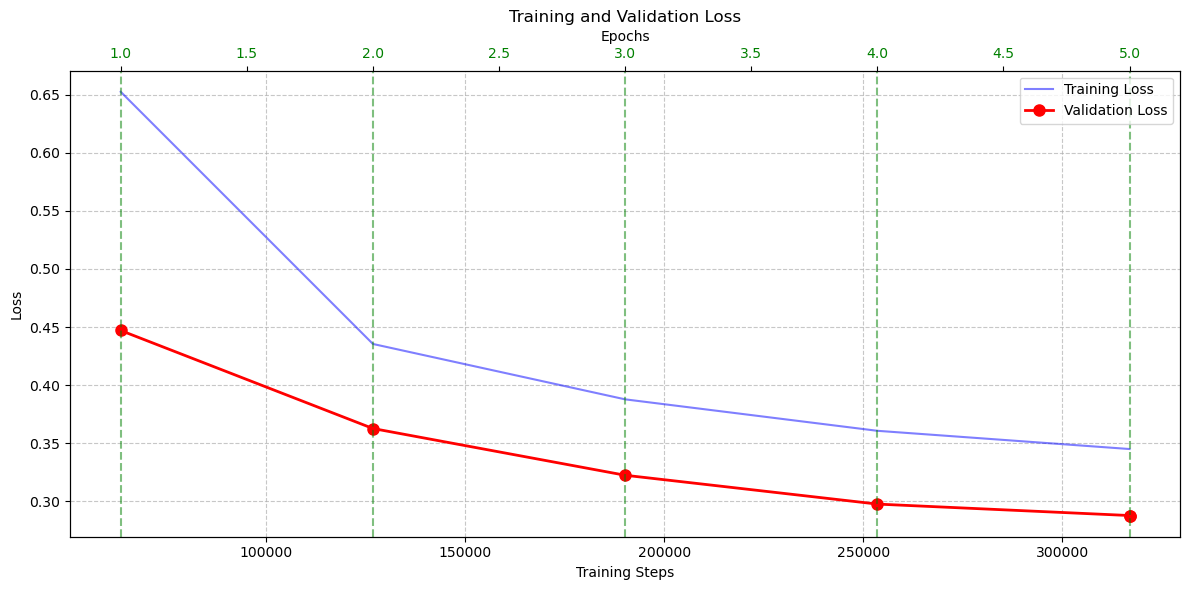

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

def plot_training_loss(trainer):
    """
    Plot training and validation loss with both epochs and steps on the x-axis.

    Parameters:
    -----------
    trainer : transformers.Trainer
        The Hugging Face trainer object after training is complete

    Returns:
    --------
    None
        Displays the plot in a Jupyter notebook
    """
    # Extract training logs
    log_history = trainer.state.log_history

    # Separate training and evaluation logs
    train_logs = [log for log in log_history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    # Extract loss values and steps
    train_loss = [log['loss'] for log in train_logs]
    train_steps = [log['step'] for log in train_logs]

    # Extract eval loss values and corresponding training steps
    eval_loss = [log['eval_loss'] for log in eval_logs]
    eval_steps = [log['step'] for log in eval_logs]

    # Calculate epochs from steps
    # We need to know the number of steps per epoch
    steps_per_epoch = trainer.args.steps_per_epoch if hasattr(trainer.args, 'steps_per_epoch') else None

    if steps_per_epoch is None:
        # Try to calculate it from training arguments
        if hasattr(trainer.args, 'num_train_epochs') and hasattr(trainer.args, 'max_steps'):
            if trainer.args.max_steps > 0 and trainer.args.num_train_epochs > 0:
                steps_per_epoch = trainer.args.max_steps / trainer.args.num_train_epochs

    if steps_per_epoch is None:
        # Fall back to estimating from the data
        # Identify epoch boundaries in the logs
        epoch_changes = [i for i, log in enumerate(log_history) if 'epoch' in log and (i == 0 or log['epoch'] > log_history[i-1].get('epoch', 0))]
        if len(epoch_changes) > 1:
            steps_per_epoch = (log_history[epoch_changes[1]]['step'] - log_history[epoch_changes[0]]['step'])

    # Create figure with two x-axes
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot training loss vs steps
    ax1.plot(train_steps, train_loss, label='Training Loss', color='blue', alpha=0.5)
    ax1.plot(eval_steps, eval_loss, label='Validation Loss', color='red',
             marker='o', linestyle='-', linewidth=2, markersize=8)

    ax1.set_xlabel('Training Steps')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='x', labelcolor='black')

    # Create a second x-axis for epochs
    if steps_per_epoch:
        ax2 = ax1.twiny()

        # Get the current x-limits
        xlim = ax1.get_xlim()

        # Set the second x-axis limits using epochs
        ax2.set_xlim([xlim[0]/steps_per_epoch, xlim[1]/steps_per_epoch])
        ax2.set_xlabel('Epochs')
        ax2.tick_params(axis='x', labelcolor='green')

        # Add epoch markers
        for epoch in range(1, int(train_steps[-1] / steps_per_epoch) + 1):
            ax1.axvline(x=epoch * steps_per_epoch, color='green', linestyle='--', alpha=0.5)

    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add a summary table with epochs
    if steps_per_epoch:
        summary_df = pd.DataFrame({
            'Step': eval_steps,
            'Epoch': [f"{step/steps_per_epoch:.2f}" for step in eval_steps],
            'Validation Loss': [f"{loss:.4f}" for loss in eval_loss]
        })
    else:
        summary_df = pd.DataFrame({
            'Step': eval_steps,
            'Validation Loss': [f"{loss:.4f}" for loss in eval_loss]
        })

    print("Validation Loss Summary:")
    display(summary_df)

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the training and validation losses
plot_training_loss(trainer)

# Metrics

In [54]:
import math
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 1.33


We'll likely need to create our prompt input type thing down here...

### Simple Prompting

In [55]:
def generate_text(model, tokenizer, prompt, max_length=100, num_return_sequences=1, temperature=1.0):
    """
    Generate text using the trained GPT2 model.

    Args:
        model: The trained GPT2 model
        tokenizer: The tokenizer used for encoding/decoding text
        prompt: The input prompt text to generate from
        max_length: Maximum length of generated sequence
        num_return_sequences: Number of sequences to generate
        temperature: Controls randomness (higher = more random)

    Returns:
        List of generated text sequences
    """
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Encode the input prompt
    encoded_prompt = tokenizer(prompt, return_tensors='pt').to(device)

    # Generate text
    with torch.no_grad():
        output_sequences = model.generate(
            input_ids=encoded_prompt['input_ids'],
            attention_mask=encoded_prompt['attention_mask'],
            max_length=max_length,
            temperature=temperature,
            num_return_sequences=num_return_sequences,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
        )

    # Decode and return the generated sequences
    generated_sequences = []
    for generated_sequence in output_sequences:
        generated_text = tokenizer.decode(generated_sequence, skip_special_tokens=True)
        generated_sequences.append(generated_text)

    return generated_sequences

In [56]:
generate_text(gptmodel, tokenizer_fast, "llanowar elves", max_length=100, num_return_sequences=1, temperature=1.0)

['llanowar elves> G Identity , Tutor , G Color , Sorcery , {3} {G} Cost <CARD_NAME> <name> <MANA_COST> {3} {G} <TYPE_LINE> Sorcery <ORACLE_TEXT> Search your library for up to two basic land cards . Reveal them , put one onto the battlefield tapped and the rest on the bottom of your library in a random order . If you search your library this way , shuffle . If you search']

In [57]:
generate_text(gptmodel, tokenizer_fast,
              "<THEMES> Extra Turn, Creature, R Color, {R} {R} Cost <CARD_NAME> Bridgemaw <MANA_COST>",
              max_length=100, num_return_sequences=1, temperature=1.0)

['<THEMES> Extra Turn, Creature, R Color, {R} {R} Cost <CARD_NAME> Bridgemaw <MANA_COST> {R} {R} <TYPE_LINE> Creature — <name> <ORACLE_TEXT> Metalcraft — Metalcraft — <name> gets gets 1 0 as long as you have 13 or less life . <POWER> 4 <TOUGHNESS> 3 <TOUGHNESS> 4 <TOUGHNESS> 2 <TOUGHNESS> 3 <TOUGHNESS> 2 <TOUGHNESS']

In [58]:
generate_text(gptmodel, tokenizer_fast,
              '[start] <THEMES> B Identity',
              max_length=100, num_return_sequences=1, temperature=1.0)



['[start] <THEMES> B Identity , Transmute , Creature , {1} {B} {B} {B} Cost , Creature Based , B Color , Horror <CARD_NAME> <name> <MANA_COST> {1} {B} {B} {B} {B} <TYPE_LINE> Creature — Horror <ORACLE_TEXT> {1} {B} {B} , {T} : Target creature gets -1 -1 until end of turn']

### More Advanced Prompting

In [59]:
# This has some nucleus sampling and top-k sampling
# This is likely for us a better way to generate text

from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load  trained model and tokenizer
# model = GPT2LMHeadModel.from_pretrained("./model/path")
# tokenizer = GPT2TokenizerFast.from_pretrained("./tokenizer/path")

# Prepare your prompt
prompt = "<THEMES> Extra Turn, Creature, R Color, {R} {R} Cost <CARD_NAME> Bridgemaw <MANA_COST>"
# inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs = tokenizer_fast(prompt, return_tensors="pt").to(device)


# TODO: change `gptmodel` to `model` and `tokenizer_fast` to `tokenizer`
# Generate text
outputs = gptmodel.generate(
    inputs.input_ids.to(device),
    max_length=100,
    do_sample=True,
    temperature=0.8,
    top_k=50,
    top_p=0.95,
    no_repeat_ngram_size=2,
    pad_token_id=tokenizer_fast.pad_token_id,
    eos_token_id=tokenizer_fast.eos_token_id,
)

# Decode the generated text
generated_text = tokenizer_fast.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

<THEMES> Extra Turn, Creature, R Color, {R} {R} Cost <CARD_NAME> Bridgemaw <MANA_COST> {0}} — Dreadnought <name> <ORACLE_TEXT> Metalcraft — {T} : Add {C} for each basic land type among permanents you control and a basic Forest type with another basic Mountain you don't control . Activate only as a sorcery . \n Metalcraft of basic Swamp , Leech , Rogue , and Wizard , instant


In [ ]:
def generate_on_test_set(model, tokenizer, test_dataset, device='cuda', max_length=100, sample_size=None, random_seed=42):
    """
    Generate outputs on a random subset of a test dataset.

    Args:
        model: The language model to use for generation
        tokenizer: The tokenizer for the model
        test_dataset: A HuggingFace dataset (typically dataset_dict['test'])
        device: Device to run inference on ('cuda' or 'cpu')
        max_length: Maximum length of generated text
        sample_size: Number of random samples to select (None = use entire dataset)
        random_seed: Seed for random sampling

    Returns:
        List of generated texts
    """
    import torch
    import random
    from tqdm.notebook import tqdm

    # Set random seed for reproducibility
    random.seed(random_seed)

    # Get indices for the entire dataset
    all_indices = list(range(len(test_dataset)))

    # Select random subset if sample_size is specified
    if sample_size is not None and sample_size < len(test_dataset):
        selected_indices = random.sample(all_indices, sample_size)
    else:
        selected_indices = all_indices

    results = []

    for idx in tqdm(selected_indices, desc="Generating"):
        # Get prompt from dataset
        prompt = test_dataset[idx]['sentence']

        # Tokenize prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        # Generate text
        outputs = model.generate(
            inputs.input_ids.to(device),
            max_length=max_length,
            do_sample=True,
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        # Decode the generated text
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        results.append({"index": idx, "prompt": prompt, "generated_text": generated_text})

    return results

# Example usage:
# # Generate texts on a random subset of 10 examples from your test set
# generated_results = generate_on_test_set(
#     model=gptmodel,
#     tokenizer=tokenizer_fast,
#     test_dataset=dataset_dict['test'],
#     device=device,
#     sample_size=10
# )

In [131]:
test_set_generations = generate_on_test_set(
    model=gptmodel,
    tokenizer=tokenizer_fast,
    test_dataset=tokenize_dataset_dict['test'],
    sample_size=200,
    device=device
)

Generating:   0%|          | 0/200 [00:00<?, ?it/s]

In [132]:
test_set_generations

[{'index': 83810,
  'prompt': '[start] <THEMES> Vampire , BRU Identity , Damage , Creature , Scry , BRU Color , {3} {U} {B} {R} Cost , Rogue <CARD_NAME> <name> <MANA_COST> {3} {U} {B} {R} <TYPE_LINE> Creature — Vampire Rogue <ORACLE_TEXT> When <name> enters , it deals 2 damage to each opponent and you scry 2 . \\n {2} , Exile <name> from your hand : Target land gains {T} : Add {U} , {B} , or {R} until <name> is cast from exile . You may cast',
  'generated_text': "[start] <THEMES> Vampire , BRU Identity , Damage , Creature , Scry , BRU Color , {3} {U} {B} {R} Cost , Rogue <CARD_NAME> <name> <MANA_COST> {3} {U} {B} {R} <TYPE_LINE> Creature — Vampire Rogue <ORACLE_TEXT> When <name> enters , it deals 2 damage to each opponent and you scry 2 . \\n {2} , Exile <name> from your hand : Target land gains {T} : Add {U} , {B} , or {R} until <name> is cast from exile . You may cast that card . If you do , <POWER> 4 <TOUGHNESS> 3 < 3 ( You skip your life total mana value 3 or less from the differe

In [ ]:
with open('./generated_test_set.txt', 'w') as f:
    for item in test_set_generations:
        f.write("%s\n" % item)

In [110]:
tokenize_dataset_dict['test']['sentence'][0]

'[start] <THEMES> Druid , Creature , Vigilance , GW Color , GW Identity , Human , Knight , {G} {W} Cost <CARD_NAME> <name> <MANA_COST> {G} {W} <TYPE_LINE> Creature — Human Druid Knight <ORACLE_TEXT>'

In [111]:
def generate_cards(model, tokenizer, dataset, prompt_template, device='cuda', 
                  max_length=100, temperature=0.8, top_k=50, top_p=0.95, 
                  no_repeat_ngram_size=2, batch_size=8, num_samples=None):
    """
    Generate Magic card text from prompts in a dataset.
    
    Args:
        model: The language model to use for generation
        tokenizer: The tokenizer for the model
        dataset: A HuggingFace dataset (or subset) containing prompts
        prompt_template: Template string with placeholders for dataset fields
        device: Device to run inference on ('cuda' or 'cpu')
        max_length: Maximum length of generated text
        temperature: Controls randomness (higher = more random)
        top_k: Number of highest probability tokens to consider
        top_p: Cumulative probability threshold for nucleus sampling
        no_repeat_ngram_size: Size of n-grams to avoid repeating
        batch_size: Number of examples to process at once
        num_samples: Optional limit on number of samples to process
        
    Returns:
        List of dictionaries containing original inputs and generated outputs
    """
    import torch
    from tqdm.notebook import tqdm
    
    results = []
    
    # Limit samples if specified
    if num_samples is not None:
        dataset = dataset.select(range(min(num_samples, len(dataset))))
    
    # Process in batches for efficiency
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        batch_prompts = []
        
        # Create prompts for each example in batch
        for example in batch:
            # Format the prompt using the template and fields from the dataset
            # This assumes the prompt template has placeholders matching dataset fields
            # Example: "<THEMES> {themes} <CARD_NAME> {name} <MANA_COST>"
            formatted_prompt = prompt_template
            
            # Replace each placeholder with corresponding dataset value
            for key, value in example.items():
                placeholder = "{" + key + "}"
                if placeholder in formatted_prompt:
                    formatted_prompt = formatted_prompt.replace(placeholder, str(value))
            
            batch_prompts.append(formatted_prompt)
        
        # Tokenize all prompts in batch
        inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True).to(device)
        
        # Generate text for all prompts in batch
        with torch.no_grad():
            outputs = model.generate(
                inputs.input_ids,
                max_length=max_length,
                do_sample=True,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                no_repeat_ngram_size=no_repeat_ngram_size,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        # Decode all generated outputs
        generated_texts = [tokenizer.decode(output, skip_special_tokens=True) 
                          for output in outputs]
        
        # Store results
        for j, text in enumerate(generated_texts):
            result = {**batch[j], 'generated_text': text, 'prompt': batch_prompts[j]}
            results.append(result)
            
    return results

In [112]:
prompt_template = "<THEMES> {themes} <CARD_NAME> {name} <MANA_COST>"

In [113]:
test_outputs = generate_cards(gptmodel, tokenizer_fast, tokenize_dataset_dict['test'], prompt_template, device=device, num_samples=10)

AttributeError: 'str' object has no attribute 'items'